##### [sample solution, trained for a few hours (not converged)]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [12]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="ms_pacman"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 5

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [11]:
i = 0

In [13]:
DIR = "plays/"

In [16]:
import gym

# env = gym.make('MsPacman-v0')
atari = gym.make('Alien-v0')
print(atari.action_space)
print(atari.observation_space)
atari.monitor.start(DIR + 'atari-experiment-' + str(i))
atari.reset()

for episode in range(2):
    obervation = atari.reset()
    total_reward = 0
    for time in range(1000):
        atari.render()
        action = atari.action_space.sample()
        observation, reward, done, info = atari.step(action)
        total_reward = total_reward + reward
        if done:
            print("Episode {}:".format(episode))
            print("  completed in {} steps".format(time+1))
            print("  total_reward was {}".format(total_reward))
            break

atari.monitor.close()
i = i + 1

[2016-10-28 15:02:08,011] Making new env: Alien-v0
[2016-10-28 15:02:08,080] Creating monitor directory plays/atari-experiment-2
[2016-10-28 15:02:08,152] Starting new video recorder writing to /Users/rikachka/Мфти/4 курс/7 семестр/Машинка/hw7 - dqn binder/plays/atari-experiment-2/openaigym.video.3.22587.video000000.mp4
[2016-10-28 15:02:08,240] Starting new video recorder writing to /Users/rikachka/Мфти/4 курс/7 семестр/Машинка/hw7 - dqn binder/plays/atari-experiment-2/openaigym.video.3.22587.video000001.mp4


Discrete(18)
Box(210, 160, 3)


[2016-10-28 15:02:20,265] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/plays/atari-experiment-2')


Episode 2:
  completed in 909 steps
  total_reward was 130.0


[2016-10-28 15:03:04,364] Making new env: Alien-v0


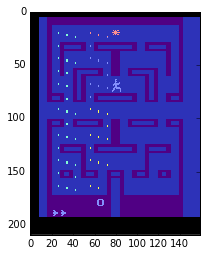

In [18]:
atari = gym.make('Alien-v0')
atari.reset()

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

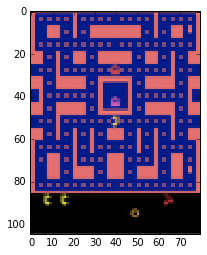

In [13]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [14]:
import lasagne

In [15]:
from lasagne.layers import InputLayer, DimshuffleLayer

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))




In [16]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(observation_reshape,16,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),32,filter_size=(4,4),stride=(2,2),name='conv1')

conv2 = Conv2DLayer(batch_norm(conv1),64,filter_size=(4,4),stride=(2,2),name='conv2')

dense0 = DenseLayer(batch_norm(conv2),256,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [17]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [18]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)


In [20]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 conv2.W,
 conv2_bn.beta,
 conv2_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [21]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE,max_size=10000)


In [22]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log][:2])
print(reward_log[:2])

[['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']
 ['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 352 ms, sys: 15.5 ms, total: 368 ms
Wall time: 363 ms


In [23]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [24]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [25]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [26]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [27]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [28]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-28 15:25:31,185] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 15:25:31,186] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 15:25:31,247] Starting new video recorder writing to /Users/rikachka/Мфти/4 курс/7 семестр/Машинка/hw7 - dqn binder/records/openaigym.video.0.23242.video000000.mp4
[2016-10-28 15:25:38,663] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 985 timesteps with reward=260.0


In [29]:
from IPython.display import HTML

video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

iter=10	epsilon=0.496	reward/step=0.00000
iter=20	epsilon=0.491	reward/step=0.00000
iter=30	epsilon=0.487	reward/step=0.14194
iter=40	epsilon=0.482	reward/step=0.30732
iter=50	epsilon=0.478	reward/step=0.32549
iter=60	epsilon=0.474	reward/step=0.32459
iter=70	epsilon=0.470	reward/step=0.34085
iter=80	epsilon=0.465	reward/step=0.31358
iter=90	epsilon=0.461	reward/step=0.29890


[2016-10-28 15:35:25,475] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 15:35:25,481] Clearing 4 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.457	reward/step=0.28713


[2016-10-28 15:35:34,180] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 1605 timesteps with reward=390.0


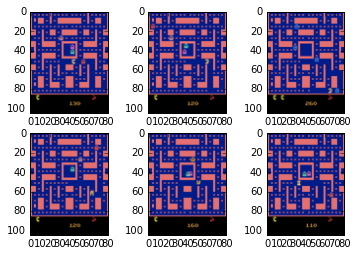

iter=110	epsilon=0.453	reward/step=0.30991
iter=120	epsilon=0.449	reward/step=0.30744
iter=130	epsilon=0.445	reward/step=0.30229
iter=140	epsilon=0.441	reward/step=0.29504
iter=150	epsilon=0.437	reward/step=0.28742
iter=160	epsilon=0.433	reward/step=0.28075
iter=170	epsilon=0.430	reward/step=0.27836
iter=180	epsilon=0.426	reward/step=0.27072
iter=190	epsilon=0.422	reward/step=0.27330


[2016-10-28 15:51:13,263] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 15:51:13,268] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.418	reward/step=0.26866


[2016-10-28 15:51:17,797] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 813 timesteps with reward=230.0


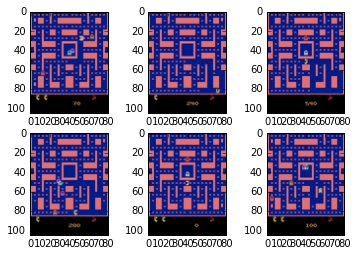

iter=210	epsilon=0.415	reward/step=0.26730
iter=220	epsilon=0.411	reward/step=0.26787
iter=230	epsilon=0.408	reward/step=0.27792
iter=240	epsilon=0.404	reward/step=0.27967
iter=250	epsilon=0.400	reward/step=0.29004
iter=260	epsilon=0.397	reward/step=0.29042
iter=270	epsilon=0.394	reward/step=0.29299
iter=280	epsilon=0.390	reward/step=0.28897
iter=290	epsilon=0.387	reward/step=0.28660


[2016-10-28 16:14:12,078] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 16:14:12,091] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.383	reward/step=0.28505


[2016-10-28 16:14:20,030] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 1465 timesteps with reward=510.0


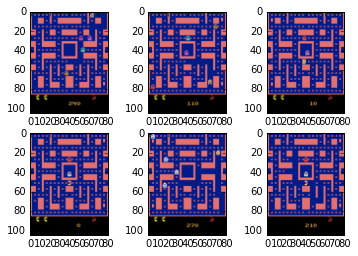

iter=310	epsilon=0.380	reward/step=0.28617
iter=320	epsilon=0.377	reward/step=0.28972
iter=330	epsilon=0.374	reward/step=0.29366
iter=340	epsilon=0.370	reward/step=0.29326
iter=350	epsilon=0.367	reward/step=0.29117
iter=360	epsilon=0.364	reward/step=0.29418
iter=370	epsilon=0.361	reward/step=0.29164
iter=380	epsilon=0.358	reward/step=0.29186
iter=390	epsilon=0.355	reward/step=0.28645


[2016-10-28 16:46:37,528] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 16:46:37,536] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.352	reward/step=0.28229


[2016-10-28 16:46:44,495] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 1213 timesteps with reward=160.0


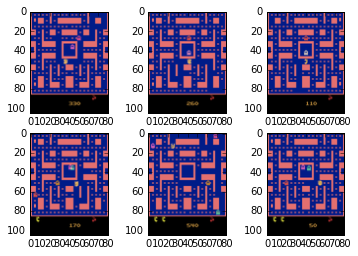

iter=410	epsilon=0.349	reward/step=0.27835
iter=420	epsilon=0.346	reward/step=0.27506
iter=430	epsilon=0.343	reward/step=0.27564
iter=440	epsilon=0.340	reward/step=0.27619
iter=450	epsilon=0.337	reward/step=0.27894
iter=460	epsilon=0.334	reward/step=0.27983
iter=470	epsilon=0.331	reward/step=0.28323
iter=480	epsilon=0.328	reward/step=0.28358
iter=490	epsilon=0.326	reward/step=0.30061


[2016-10-28 17:32:50,213] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 17:32:50,226] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.323	reward/step=0.30858


[2016-10-28 17:32:55,452] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 957 timesteps with reward=170.0


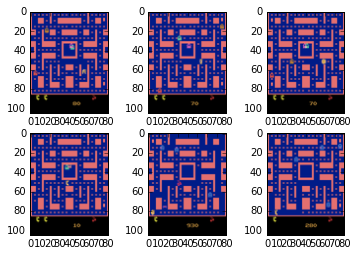

iter=510	epsilon=0.320	reward/step=0.30998
iter=520	epsilon=0.318	reward/step=0.30864
iter=530	epsilon=0.315	reward/step=0.31111
iter=540	epsilon=0.312	reward/step=0.30832
iter=550	epsilon=0.310	reward/step=0.30744
iter=560	epsilon=0.307	reward/step=0.30695
iter=570	epsilon=0.304	reward/step=0.30963
iter=580	epsilon=0.302	reward/step=0.30912
iter=590	epsilon=0.299	reward/step=0.30626


[2016-10-28 19:09:44,352] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:09:44,381] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.297	reward/step=0.30250


[2016-10-28 19:09:50,867] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 1181 timesteps with reward=380.0


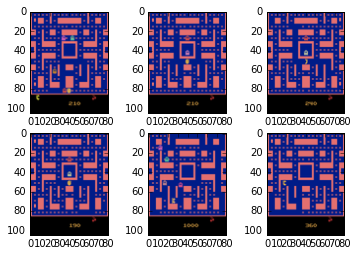

iter=610	epsilon=0.295	reward/step=0.29918
iter=620	epsilon=0.292	reward/step=0.29694
iter=630	epsilon=0.290	reward/step=0.29635
iter=640	epsilon=0.287	reward/step=0.29704
iter=650	epsilon=0.285	reward/step=0.29555
iter=660	epsilon=0.283	reward/step=0.29471
iter=670	epsilon=0.280	reward/step=0.29151
iter=680	epsilon=0.278	reward/step=0.28811
iter=690	epsilon=0.276	reward/step=0.28886


[2016-10-28 21:09:46,490] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 21:09:46,531] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.273	reward/step=0.29187


[2016-10-28 21:09:52,067] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/rikachka/\xd0\x9c\xd1\x84\xd1\x82\xd0\xb8/4 \xd0\xba\xd1\x83\xd1\x80\xd1\x81/7 \xd1\x81\xd0\xb5\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd1\x80/\xd0\x9c\xd0\xb0\xd1\x88\xd0\xb8\xd0\xbd\xd0\xba\xd0\xb0/hw7 - dqn binder/records')


Episode finished after 1017 timesteps with reward=290.0


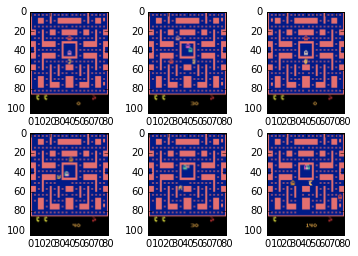

iter=710	epsilon=0.271	reward/step=0.29423
iter=720	epsilon=0.269	reward/step=0.29598
iter=730	epsilon=0.267	reward/step=0.29603
iter=740	epsilon=0.265	reward/step=0.29609
iter=750	epsilon=0.263	reward/step=0.29507


KeyboardInterrupt: 

In [ ]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**10):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(5):
        loss = train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        

    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%rw)

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__